# Setup

In [23]:
import numpy as np
import pandas as pd
import scipy.optimize as optimization
import matplotlib.pyplot as plt

In [5]:
from ROOT import gROOT

gROOT.LoadMacro('F.C')
from ROOT import F
f = F()

Welcome to JupyROOT 6.22/00


### Utility functions

In [56]:
def TotalUUXS_curve_fit(fixed, ReH, ReE, ReHtilde):
    phi, k, QQ, xB, t, F1, F2, dvcs = tuple(map(list, fixed))
    fs = np.zeros(len(phi))
    for i in range(len(fs)):
        fs[i] = f.TotalUUXS(phi[i], k[i], QQ[i], xB[i], t[i], F1[i], F2[i], ReH, ReE, ReHtilde, dvcs[i])
    return fs

In [7]:
def red_chi2(y, yhat, sigma, ndf):
    """
    y is the observed values, yhat is the estimated values, sigma is errf, and ndf is the number of
    observations minus the number of free parameters.  All should be 1d-arrays except ndf, which is scalar.
    """
    assert len(y) == len(yhat) == len(sigma)
    return np.sum(np.square(y-yhat)/np.square(sigma))/ndf

# Fit all sets

In [8]:
df = pd.read_csv("dvcs_xs_newsets.csv")

In [70]:
i=3

In [71]:
X = (df.loc[i*36:(i+1)*36-1, 'phi_x'], df.loc[i*36:(i+1)*36-1, 'k'], df.loc[i*36:(i+1)*36-1, 'QQ'], df.loc[i*36:(i+1)*36-1, 'x_b'], df.loc[i*36:(i+1)*36-1, 't'],
         df.loc[i*36:(i+1)*36-1, 'F1'], df.loc[i*36:(i+1)*36-1, 'F2'], df.loc[i*36:(i+1)*36-1, 'dvcs'])

y = df.loc[i*36:(i+1)*36-1, 'F']
sigma = df.loc[i*36:(i+1)*36-1, 'errF']
pars0 = np.array([1, 1, 1]) # initial guesses for cffs

cff, cffcov = optimization.curve_fit(TotalUUXS_curve_fit, X, y, pars0, sigma, method='lm')
perr = np.sqrt(np.diag(cffcov))

print(red_chi2(df.loc[i*36:(i+1)*36-1, 'F'], TotalUUXS_curve_fit(X, *cff), df.loc[i*36:(i+1)*36-1, 'errF'], 33))

pd.DataFrame({'Fitted': cff,
              'EstError': perr},
             ['ReH', 'ReE', 'ReHTilde'])

1.1037156685901617


,Fitted,EstError
ReH,8.982135,2.945940
ReE,-54.485782,14.852145
ReHTilde,4.516039,1.118831


In [73]:
cffs = []
errs = []

for i in range(df["#Set"].max()+1):   # loop through all sets of kinematics
    X = (df.loc[i*36:(i+1)*36-1, 'phi_x'], df.loc[i*36:(i+1)*36-1, 'k'], df.loc[i*36:(i+1)*36-1, 'QQ'],
         df.loc[i*36:(i+1)*36-1, 'x_b'], df.loc[i*36:(i+1)*36-1, 't'], df.loc[i*36:(i+1)*36-1, 'F1'],
         df.loc[i*36:(i+1)*36-1, 'F2'], df.loc[i*36:(i+1)*36-1, 'dvcs'])

    y = df.loc[i*36:(i+1)*36-1, 'F']
    sigma = df.loc[i*36:(i+1)*36-1, 'errF']
    pars0 = np.array([1, 1, 1]) # initial guesses for cffs

    cff, cffcov = optimization.curve_fit(TotalUUXS_curve_fit, X, y, pars0, sigma, method='lm')

    perr = np.sqrt(np.diag(cffcov))
    
    cffs.append(tuple(cff))
    errs.append(tuple(perr))
    
    print(i)
    print("Reduced Chi2: " + str(red_chi2(df.loc[i*36:(i+1)*36-1, 'F'], TotalUUXS_curve_fit(X, *cff), df.loc[i*36:(i+1)*36-1, 'errF'], 33)))
    print("\n")
    print(pd.DataFrame({'Fitted': cff,
                  'Error': perr},
                 ['ReH', 'ReE', 'ReHTilde']))
    print("\n")

0
Reduced Chi2: 1.0045288482467714


             Fitted     Error
ReH       13.878755  1.116576
ReE      -57.383343  5.740966
ReHTilde   6.799729  0.630739


1
Reduced Chi2: 0.9544931466340011


             Fitted      Error
ReH       11.719817   2.559194
ReE      -47.746209  13.450243
ReHTilde   7.488039   1.250604


2
Reduced Chi2: 0.5965021594421849


             Fitted      Error
ReH        6.540862   2.028538
ReE      -43.195876  11.627438
ReHTilde   4.484700   0.742568


3
Reduced Chi2: 1.1037156685901617


             Fitted      Error
ReH        8.982135   2.945940
ReE      -54.485782  14.852145
ReHTilde   4.516039   1.118831


4
Reduced Chi2: 0.9493673159237621


             Fitted     Error
ReH       11.693827  1.211438
ReE      -47.947156  6.219190
ReHTilde   7.354355  0.676689


5
Reduced Chi2: 0.5963363615296935


             Fitted     Error
ReH        6.719193  1.419693
ReE      -44.275317  8.062980
ReHTilde   4.268059  0.486565


6
Reduced Chi2: 0.973718880917646


# Analysis

In [74]:
compare = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")

### Pct Error

In [84]:
def pcterr(obs, exp):
    return 100*(obs-exp)/exp

pcterrs = pd.DataFrame({
  "ReH": np.zeros(15),
  "ReE": np.zeros(15),
  "ReHtilde": np.zeros(15)
})

for i in range(compare["#Set"].max()+1):
    pcterrs.loc[i, "ReH"] = pcterr(compare.loc[i*36, "ReH"], cffs[i][0])
    pcterrs.loc[i, "ReE"] = pcterr(compare.loc[i*36, "ReE"], cffs[i][1])
    pcterrs.loc[i, "ReHtilde"] = pcterr(compare.loc[i*36, "ReHtilde"], cffs[i][2])

pcterrs

,ReH,ReE,ReHtilde
0,-5.932485,-7.542159,6.666313
1,7.125392,10.071356,-6.852250
2,10.447821,9.325715,-10.507504
3,-14.800656,-12.541037,-5.857552
4,7.363486,9.610047,-5.159053
5,7.516481,6.660332,-5.964990
6,15.435134,20.736618,-6.168808
7,-13.750627,-11.619044,-12.904011
8,6.770247,8.713403,-3.738564
9,-13.699405,-12.312984,22.993045


### Mean Pct Errors

In [86]:
print("ReH: " + str(np.mean(np.abs(pcterrs["ReH"]))))
print("ReE: " + str(np.mean(np.abs(pcterrs["ReE"]))))
print("ReHtilde: " + str(np.mean(np.abs(pcterrs["ReHtilde"]))))

ReH: 9.854114201245272
ReE: 10.470014645277974
ReHtilde: 8.026472507756187


## Graphs

In [106]:
np.array((range(len(ReHs))))*36

array([  0,  36,  72, 108, 144, 180, 216, 252, 288, 324, 360, 396, 432,
       468, 504])

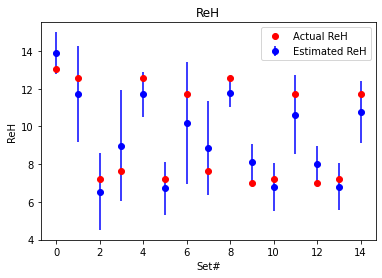

In [115]:
ReHs = list(map(lambda x: x[0], cffs))
ReHerrs = list(map(lambda x: x[0], errs))

fig, ax = plt.subplots()
ax.errorbar(list(range(len(ReHs))), ReHs, fmt='bo', yerr=ReHerrs, label="Estimated ReH")
ax.plot(list(range(len(ReHs))), compare.loc[np.array((range(len(ReHs))))*36, 'ReH'], 'ro', label="Actual ReH")
ax.set_xlabel("Set#")
ax.set_ylabel("ReH")
ax.set_title("ReH")
ax.legend()

plt.show()

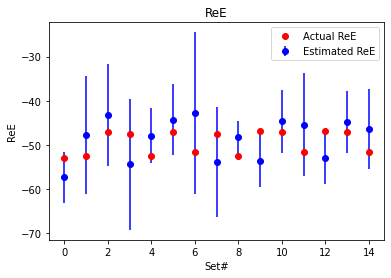

In [116]:
ReEs = list(map(lambda x: x[1], cffs))
ReEerrs = list(map(lambda x: x[1], errs))

fig, ax = plt.subplots()
ax.errorbar(list(range(len(ReEs))), ReEs, fmt='bo', yerr=ReEerrs, label="Estimated ReE")
ax.plot(list(range(len(ReEs))), compare.loc[np.array((range(len(ReEs))))*36, 'ReE'], 'ro', label="Actual ReE")
ax.set_xlabel("Set#")
ax.set_ylabel("ReE")
ax.set_title("ReE")
ax.legend()

plt.show()

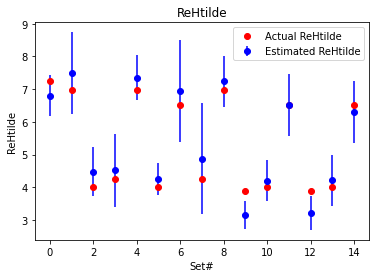

In [117]:
ReHtildes = list(map(lambda x: x[2], cffs))
ReHtildeerrs = list(map(lambda x: x[2], errs))

fig, ax = plt.subplots()
ax.errorbar(list(range(len(ReHtildes))), ReHtildes, fmt='bo', yerr=ReHtildeerrs, label="Estimated ReHtilde")
ax.plot(list(range(len(ReHtildes))), compare.loc[np.array((range(len(ReHtildes))))*36, 'ReHtilde'], 'ro', label="Actual ReHtilde")
ax.set_xlabel("Set#")
ax.set_ylabel("ReHtilde")
ax.set_title("ReHtilde")
ax.legend()

plt.show()